# VAEP 분석 리포트

이 노트북은 `vaep_values.csv` 파일을 분석하여 경기의 전술적 흐름과 선수들의 기여도를 파악합니다.

## 1. 환경 설정 및 데이터 로드

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

VAEP_PATH = '../results/vaep_values.csv'
MATCH_INFO_PATH = '../data/match_info.csv'

df_vaep = pd.read_csv(VAEP_PATH)
df_match = pd.read_csv(MATCH_INFO_PATH)

print(f"VAEP Data Loaded: {len(df_vaep)} rows")
display(df_vaep.head())

VAEP Data Loaded: 504242 rows


,game_id,period_id,time_seconds,team_id,player_id,type_name,result_name,offensive_value,defensive_value,vaep_value
0,126283,1,0.667,2354,344559.0,pass,success,0.000000,-0.000000,0.000000
1,126283,1,2.833,2354,250036.0,pass,fail,0.000731,-0.000147,0.000584
2,126283,1,3.667,2354,250036.0,pass,success,-0.001057,0.000095,-0.000961
3,126283,1,4.967,2354,500145.0,pass,fail,0.000613,-0.000060,0.000553
4,126283,1,4.968,2354,500145.0,dribble,fail,-0.000281,0.000071,-0.000210


## 2. 특정 경기의 팀별 VAEP 변화 분석

선택한 경기에서 시간에 따른 팀별 VAEP 변화를 시연합니다.

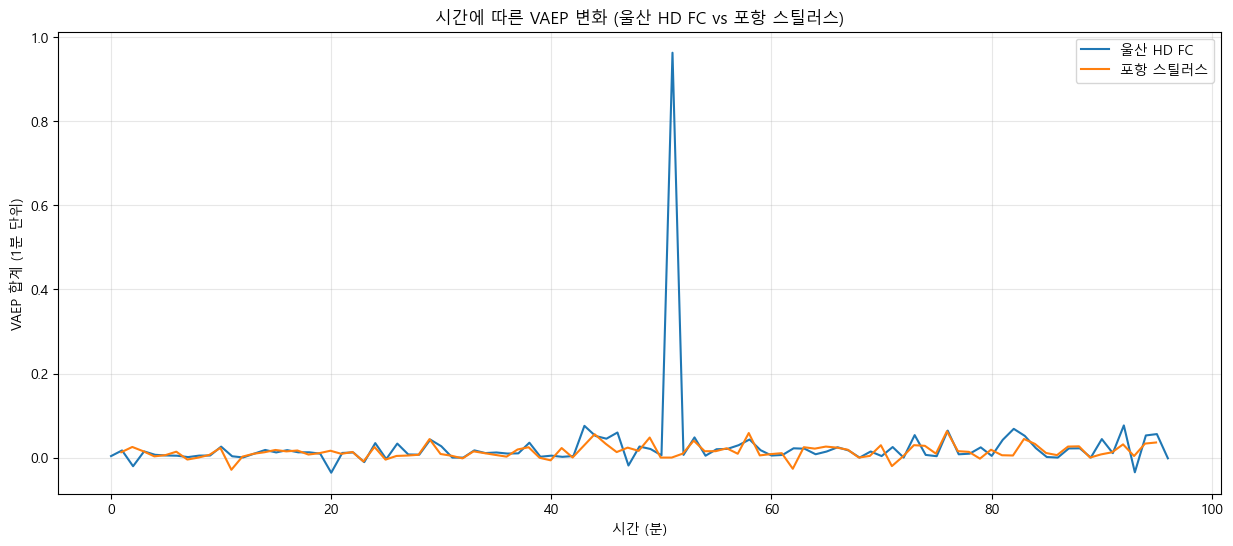

In [3]:
# 첫 번째 경기를 샘플로 선택
sample_game_id = df_vaep['game_id'].unique()[0]
game_match_info = df_match[df_match['game_id'] == sample_game_id].iloc[0]

home_team_id = game_match_info['home_team_id']
away_team_id = game_match_info['away_team_id']
home_team_name = game_match_info['home_team_name_ko']
away_team_name = game_match_info['away_team_name_ko']

df_game = df_vaep[df_vaep['game_id'] == sample_game_id].copy()
df_game['total_time'] = df_game['time_seconds'] + (df_game['period_id'] - 1) * 2700 # 대략적인 시간

plt.figure(figsize=(15, 6))
for tid, tname in [(home_team_id, home_team_name), (away_team_id, away_team_name)]:
    team_data = df_game[df_game['team_id'] == tid]
    # 1분 단위 이동 평균 적용하여 흐름 시각화
    team_data_resampled = team_data.set_index(pd.to_timedelta(team_data['total_time'], unit='s')).resample('1min')['vaep_value'].sum().fillna(0)
    plt.plot(team_data_resampled.index.total_seconds() / 60, team_data_resampled.values, label=tname)

plt.title(f"시간에 따른 VAEP 변화 ({home_team_name} vs {away_team_name})")
plt.xlabel("시간 (분)")
plt.ylabel("VAEP 합계 (1분 단위)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. 누적 VAEP 변화 (Dominance Timeline)

누적 그래프를 통해 어느 팀이 경기 전체에서 주도권을 더 많이 가졌는지 확인합니다.

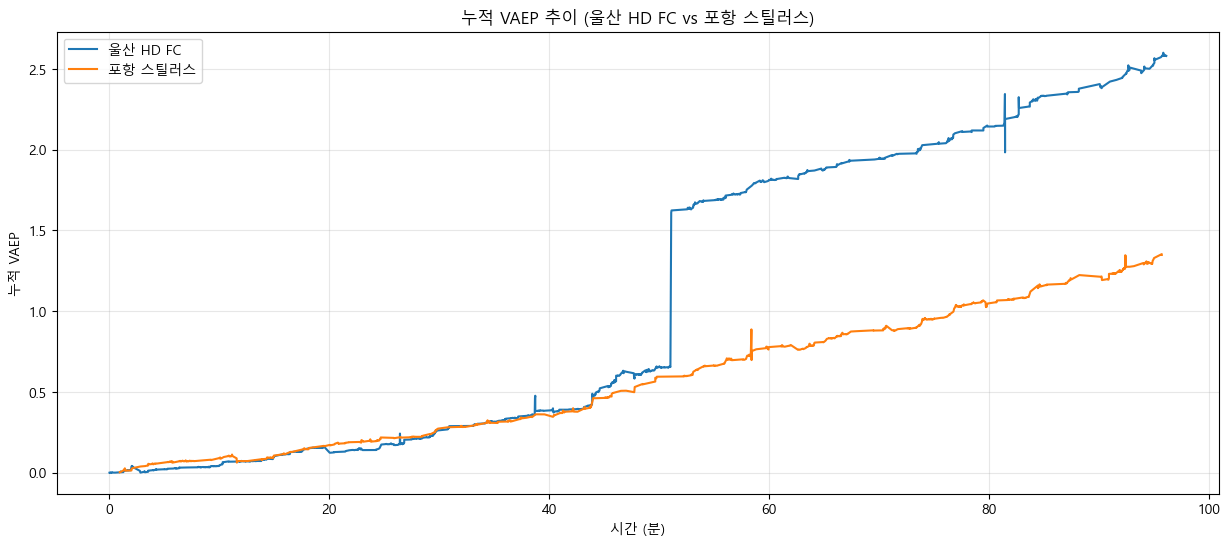

In [4]:
plt.figure(figsize=(15, 6))
for tid, tname in [(home_team_id, home_team_name), (away_team_id, away_team_name)]:
    team_data = df_game[df_game['team_id'] == tid].sort_values('total_time')
    plt.plot(team_data['total_time'] / 60, team_data['vaep_value'].cumsum(), label=tname)

plt.title(f"누적 VAEP 추이 ({home_team_name} vs {away_team_name})")
plt.xlabel("시간 (분)")
plt.ylabel("누적 VAEP")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. 액션 타입별 VAEP 기여도

어떤 플레이(패스, 드리블 등)가 가치를 가장 많이 창출했는지 분석합니다.

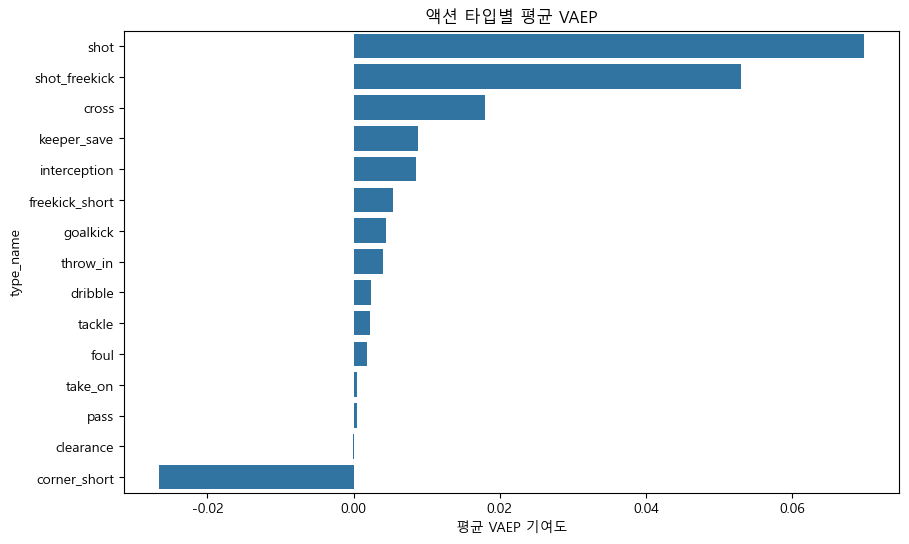

In [5]:
action_vaep = df_vaep.groupby('type_name')['vaep_value'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=action_vaep.values, y=action_vaep.index)
plt.title("액션 타입별 평균 VAEP")
plt.xlabel("평균 VAEP 기여도")
plt.show()

## 5. 경기별 최우수 선수 (TOP VAEP Players)

경기당 가장 높은 VAEP를 기록한 상위 10명의 선수를 조회합니다.

In [6]:
player_summary = df_vaep.groupby(['game_id', 'player_id'])['vaep_value'].sum().reset_index()
top_players = player_summary.sort_values('vaep_value', ascending=False).head(10)

# 선수 이름 정보가 필요할 경우 mapping 추가 가능 (raw_data에 선수명 포함됨)
display(top_players)

,game_id,player_id,vaep_value
1830,126342,250902.0,2.998227
1438,126329,410634.0,2.866433
2472,126362,358583.0,2.332433
3826,126406,62112.0,2.188283
915,126312,500117.0,2.118018
5196,126449,500549.0,2.087984
3301,126389,188342.0,2.065942
3403,126392,500563.0,2.063028
2282,126356,491835.0,2.055431
2141,126352,252489.0,2.049506
